In [52]:
!pip install tensorflow-datasets==1.2.0
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import tensorflow_datasets as tfds
import tensorflow as tf
tf.random.set_seed(1234)

In [53]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # adding a start and an end token to the sentence
    return sentence


def load_text(path_to_text, min_line_chars=75):
    texts = ""
    with open(path_to_text, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        if len(line) < min_line_chars or line[0] == '[' or line[0] == '"':
            continue
        if line.lower().startswith(path_to_text.split('.')[0].lower()):
            continue
        texts += preprocess_sentence(line.replace('\n', ''))
    return texts


text = load_text('/home/sam/lsd_small.txt')
print(f'len text {len(text)}\n Sample text: {text[220:242]}')
print(f'\n More Sample text: {text[34:45]}')

len text 832166
 Sample text:  when it turned up in 

 More Sample text: always cons


In [54]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(text, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 259


In [55]:
print(f'Sample text: {text[520:542]}')
print(f'Tokenized sample text: {len(tokenizer.encode("".join(text[520:542])))}, tokens:{tokenizer.encode("".join(text[520:542]))}')

Sample text: researched the rumors 
Tokenized sample text: 22, tokens:[115, 102, 116, 102, 98, 115, 100, 105, 102, 101, 33, 117, 105, 102, 33, 115, 118, 110, 112, 115, 116, 33]


In [193]:
# Burn in sentence length
BURN_IN = 32
TOKENS_TO_EMIT = 32

def tokenize_sliding_window(inputs, max_sentence_length, step_size=65):
    tokenized_inputs = []

    for i in range(0, len(inputs)-max_sentence_length, step_size):
        # tokenize sentence
        tokens = tokenizer.encode("".join(inputs[i:i+max_sentence_length]))
        #sentence1 = START_TOKEN + tokens[:max_sentence_length-2] + END_TOKEN
        tokenized_inputs.append(tokens)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_sentence_length, padding='post')
    return tokenized_inputs

tokenized_text = tokenize_sliding_window(text, BURN_IN+1)
print(f'Number of tokenized samples: {len(tokenized_text)}')



Number of tokenized samples: 12803


In [194]:
print(f'{len(tokenized_text[4])}\n Tokens: {tokenized_text[4]} \nDecoded: {tokenizer.decode(tokenized_text[4, 1:-1]%(VOCAB_SIZE-2))}')

33
 Tokens: [106 117 105  33 112 103  33 110 122  33 105 106 113 113 106 102  33 103
 115 106 102 111 101 116  33 120 102  33 101  33 106 111 119] 
Decoded: th of my hippie friends we d in


In [195]:
print(f'Decoded: {tokenizer.encode(" ")}')

Decoded: [33]


In [196]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_text[:, :BURN_IN],
        'dec_inputs': tokenized_text[:, -(TOKENS_TO_EMIT+1):-1]
    },
    {
        'outputs': tokenized_text[:, -TOKENS_TO_EMIT:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [197]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 32), dec_inputs: (None, 32)}, {outputs: (None, 32)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [198]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [199]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [200]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [201]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [202]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [203]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [204]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

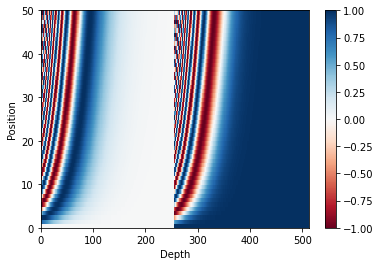

In [205]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [206]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

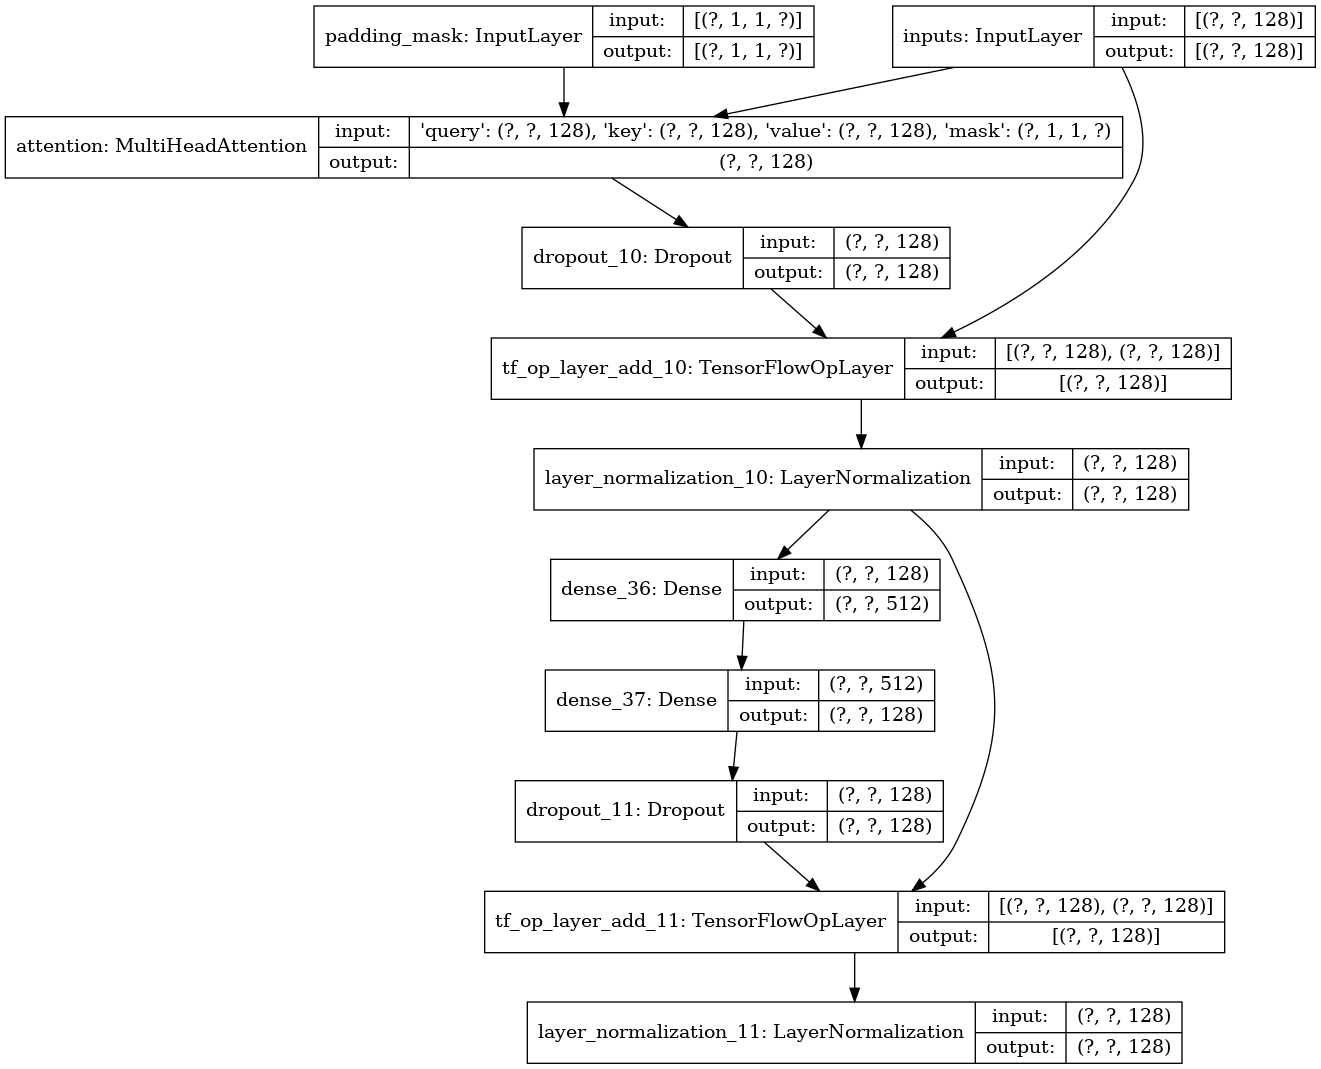

In [207]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [208]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [209]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

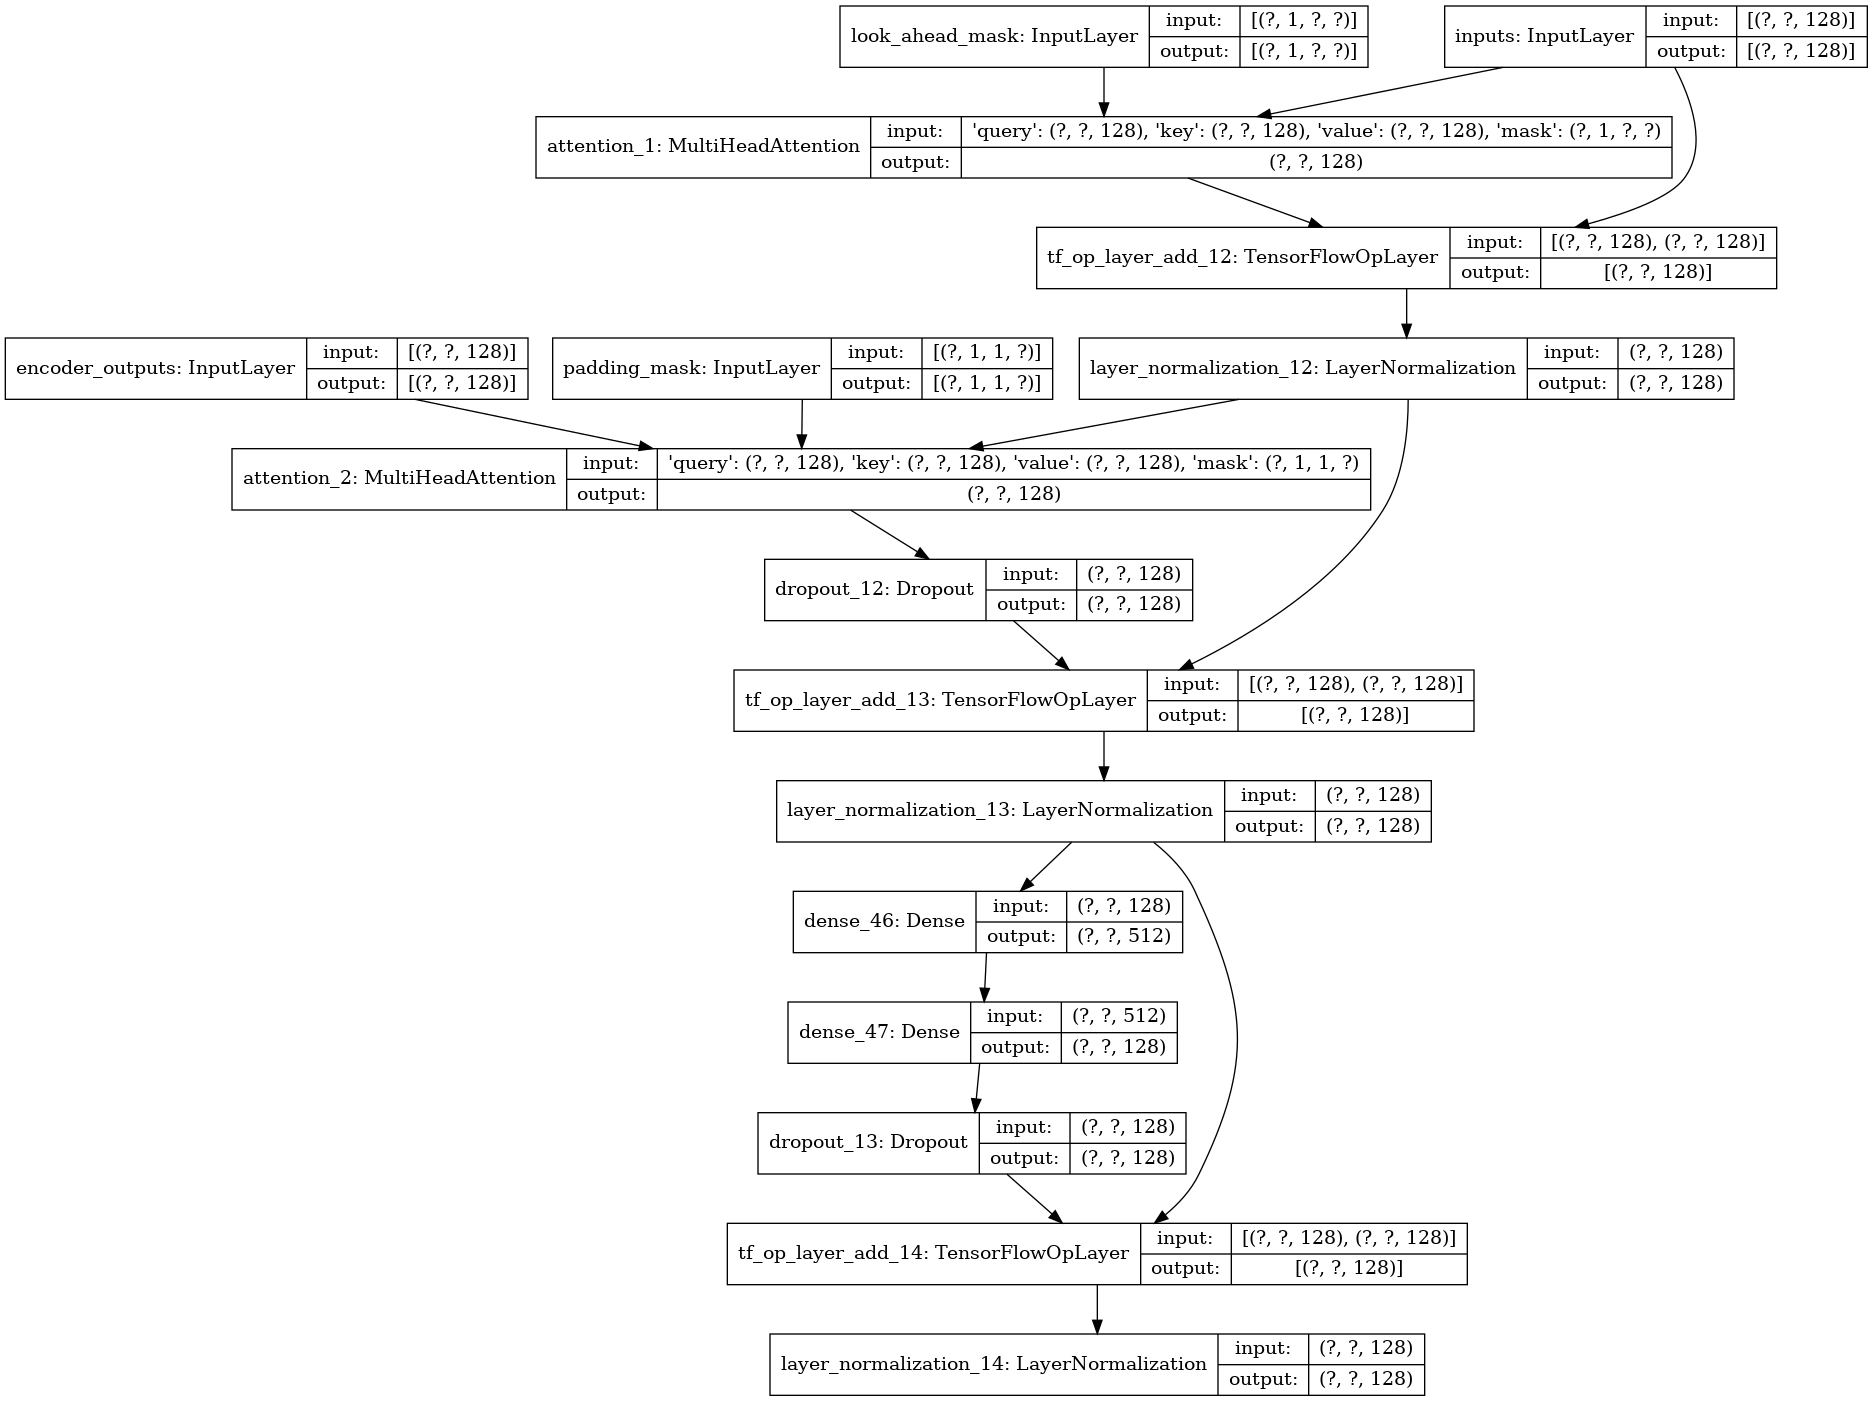

In [210]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [211]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

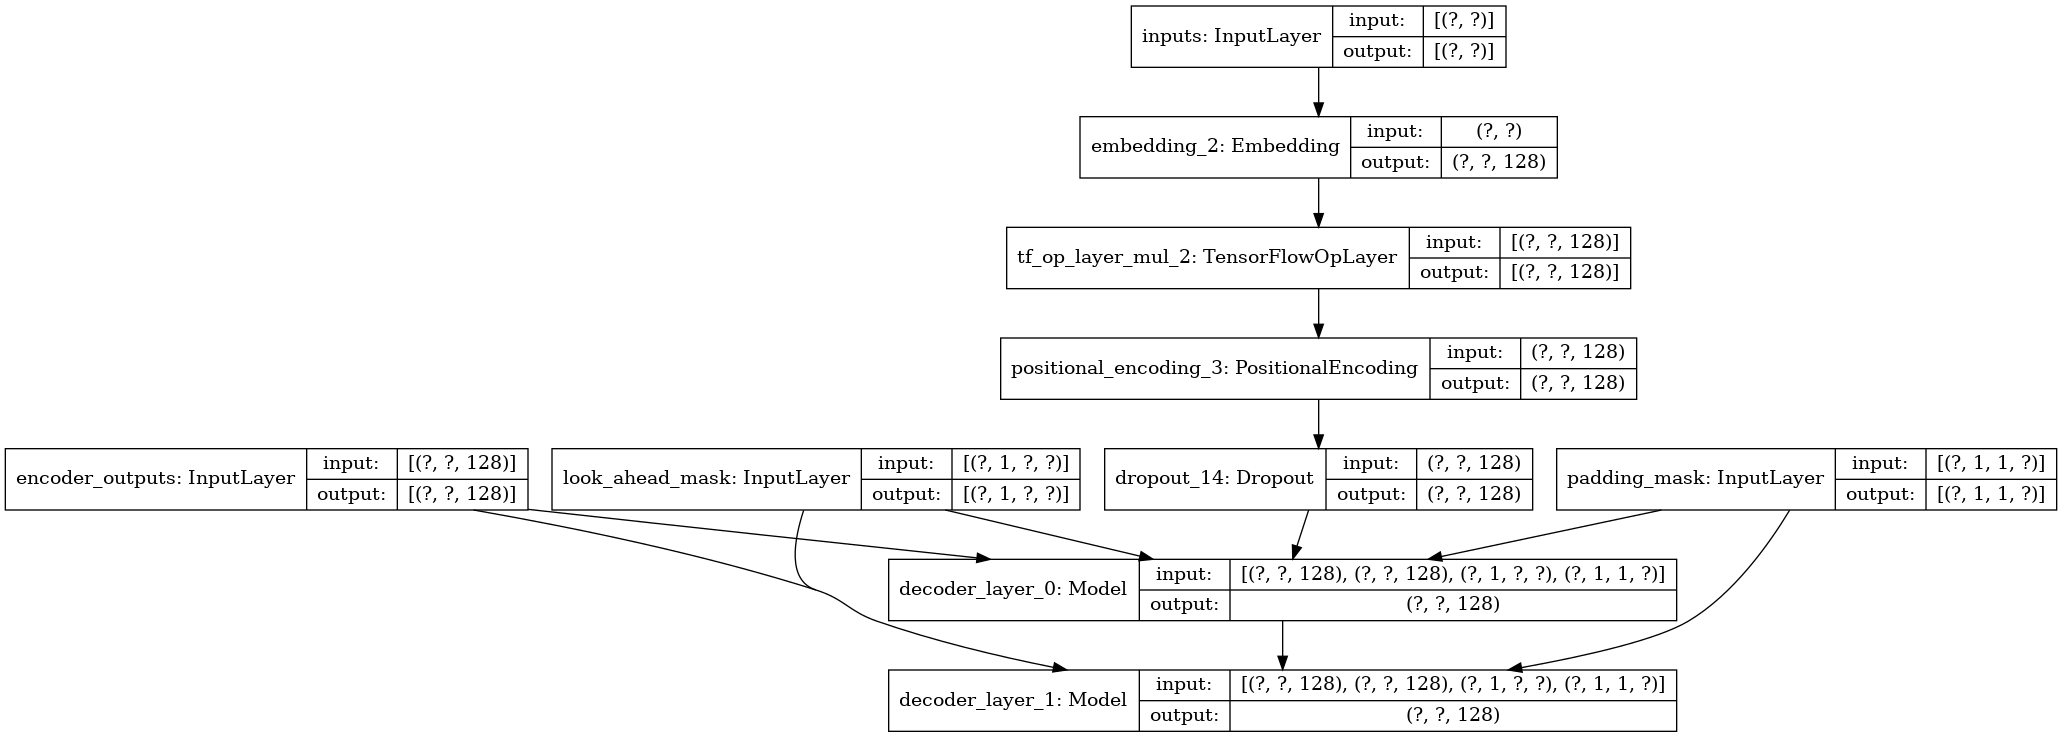

In [212]:
sample_decoder = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [213]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

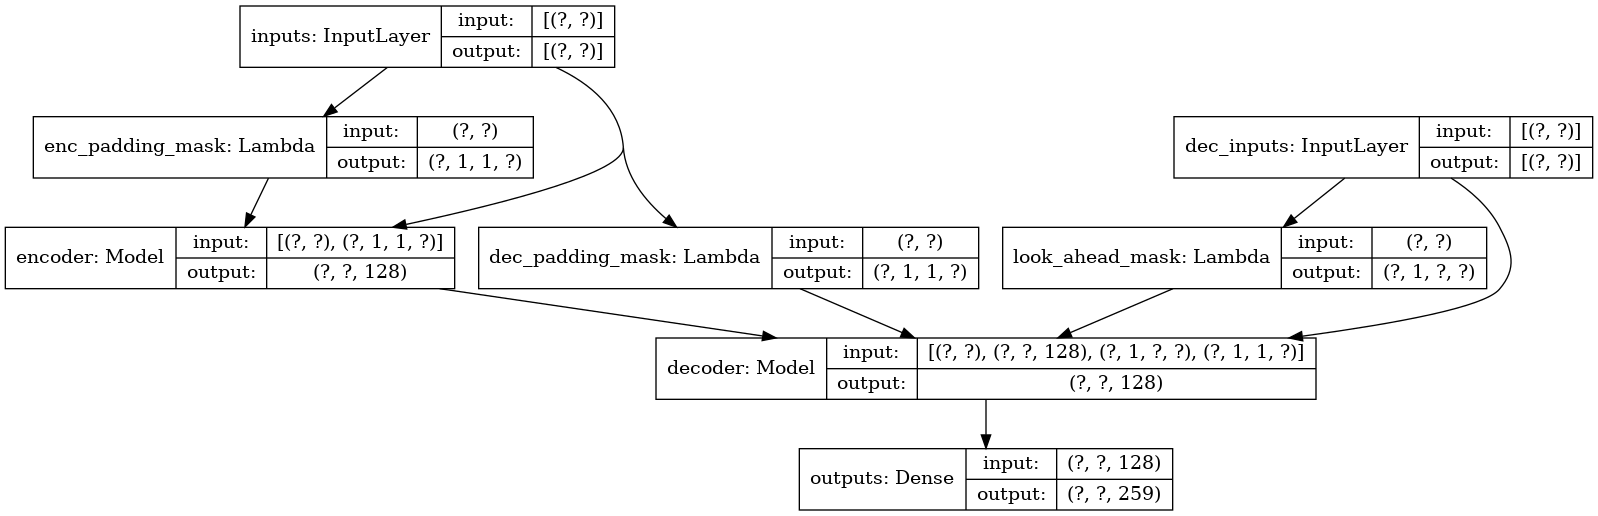

In [214]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [215]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [216]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [217]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

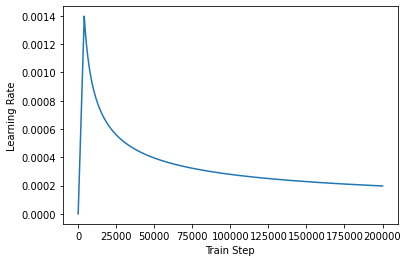

In [218]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [219]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, TOKENS_TO_EMIT)
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [220]:
EPOCHS = 80
model.fit(dataset, epochs=EPOCHS)

Train for 201 steps
Epoch 1/80
201/201 [==============================] - 23s 113ms/step - loss: 3.9126 - accuracy: 0.1728
Epoch 2/80
201/201 [==============================] - 15s 73ms/step - loss: 2.3313 - accuracy: 0.3446
Epoch 3/80
201/201 [==============================] - 15s 73ms/step - loss: 0.8103 - accuracy: 0.7689
Epoch 4/80
201/201 [==============================] - 15s 75ms/step - loss: 0.1399 - accuracy: 0.9626
Epoch 5/80
201/201 [==============================] - 15s 73ms/step - loss: 0.0914 - accuracy: 0.9744
Epoch 6/80
201/201 [==============================] - 15s 73ms/step - loss: 0.0829 - accuracy: 0.9764
Epoch 7/80
201/201 [==============================] - 15s 73ms/step - loss: 0.0783 - accuracy: 0.9772
Epoch 8/80
201/201 [==============================] - 15s 72ms/step - loss: 0.0758 - accuracy: 0.9779
Epoch 9/80
201/201 [==============================] - 15s 74ms/step - loss: 0.0737 - accuracy: 0.9784
Epoch 10/80
201/201 [==============================] - 15s 73

201/201 [==============================] - 15s 74ms/step - loss: 0.0061 - accuracy: 0.9980


In [221]:
space_id = tokenizer.encode(" ")
def evaluate(sentence):
    sentence_string = preprocess_sentence(sentence)
    output = ''
    for i in range(TOKENS_TO_EMIT):
        sentence = tf.expand_dims(tokenizer.encode(sentence_string[i:i+BURN_IN]), axis=0)
        decoder_input = tf.expand_dims(tokenizer.encode(sentence_string[-(TOKENS_TO_EMIT+1+i):(-1+i)]), axis=0)
        predictions = model(inputs=[sentence, decoder_input], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        #print(f'{predicted_id.shape}')
        output += tokenizer.decode(predicted_id[0])
        sentence_string += tokenizer.decode(predicted_id[0])
    return output

def predict(sentence):
    prediction = evaluate(sentence)
    print(f'Input: {sentence}')
    print(f'Output: {prediction}')
    return prediction

In [222]:
output = predict('I feel a little guilty about submitting this since')

Input: I feel a little guilty about submitting this since
Output: otl ulyaotsbitn hssnet 


In [223]:
output = predict("The music began and all of these emotions")

Input: The music began and all of these emotions
Output:  cbgnadalo hs mtoscgaaoh ts


In [224]:
# feed the model with its previous output
sentence = 'What kind of raving trance'
for _ in range(15):
    sentence = predict(sentence)
    print('')

Input: What kind of raving trance
Output: etkn f vi rnetnfv ntf t   n    

Input: etkn f vi rnetnfv ntf t   n    
Output: nnfvintf tf nfit fni niiii iiif

Input: nnfvintf tf nfit fni niiii iiif
Output: fvnf  ft iniiiifnff niinfnnfnnn

Input: fvnf  ft iniiiifnff niinfnnfnnn
Output: nff niinfnifnnnf innfnninniniii

Input: nff niinfnifnnnf innfnninniniii
Output: i iininn nnnnniiinn nniin ininn

Input: i iininn nnnnniiinn nniin ininn
Output: niinnnninnni nininnnniinnnininn

Input: niinnnninnni nininnnniinnnininn
Output: nnnnni nnninnninnn ninnn in i  

Input: nnnnni nnninnninnn ninnn in i  
Output: ini ninnn ini ii inii  iioiii n

Input: ini ninnn ini ii inii  iioiii n
Output: n inni iiiiiiin ni iinnninnnnn 

Input: n inni iiiiiiin ni iinnninnnnn 
Output: nni iii n nnnnnn i nnnninniniii

Input: nni iii n nnnnnn i nnnninniniii
Output: i i nnnninniniiiinniniiinnininn

Input: i i nnnninniniiiinniniiinnininn
Output: n nniiiinniinnnnnninninnnnininn

Input: n nniiiinniinnnnnninninnnnininn
Output